Processes the data file produced from the following ping script
>ping www.google.com -D -i 5 >> ping_tracker.txt

In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import matplotlib.dates as md
from matplotlib.dates import DateFormatter

class Ping_Extractor(): 
    
    def __init__(self): 
        pass

    
    def read_file(self, filepath): 
        with open(filepath, 'r') as f: 
            self.data = f.readlines()
            
    def parse_data(self, rolling_interval = 5): 
        self.ts = [self.timeconvert(l.split('[')[-1].split(']')[0]) for l in self.data[1:]]
        
        from datetime import timedelta
        self.timedeltas = []
        for i in range(1, len(self.data)-1):
            t_del = self.ts[i] - self.ts[i-1]
            self.timedeltas.append(t_del.total_seconds())
            
        self.lats = [self.latency_stripper(l) for l in self.data[1:]]
        
        df = pd.DataFrame(list(zip(self.ts[1:], self.timedeltas, self.lats[1:])), columns = ['timestamp', 'time_delta', 'latency'])
        df['datetime'] = df.timestamp.apply(lambda x: pd.to_datetime(x))
        df.sort_values('datetime', inplace=True)
        
        df['time_delta_rolling'] = df.time_delta.rolling(rolling_interval).mean().bfill()
        df['latency_rolling'] = df.latency.rolling(rolling_interval).mean().bfill()
        
        self.data_processed = df
            
    def timeconvert(self, u): 
        from datetime import datetime
        dt = datetime.fromtimestamp(float(u))
        return dt
    
    def latency_stripper(self, line): 
        
        # Some lines were not simply dropped but returns that net is not reachable. Inpute this as -20 float.
        if 'Net Unreachable' in line: 
            return float(-20)
        else: 
            return float(line.split('time=')[-1].replace(' ms\n', ''))
        
    def plot_ping_timediff(self, rolling = False):
        
        if rolling: 
            y_var = 'time_delta_rolling'
        else: 
            y_var = 'time_delta'
        
        plt.subplots(figsize=(11, 4))

        p = sns.lineplot(data = self.data_processed, x = 'datetime', y = y_var)
        plt.xlabel('Time')
        plt.ylabel('Ping Time Delta (seconds)')
        
        # Define the date format
        date_form = DateFormatter("%m-%d")
        p.xaxis.set_major_formatter(date_form)

        # Ensure a major tick for each day using (interval=1) 
        p.xaxis.set_major_locator(md.DayLocator(interval=1))
        
        return p
        
    def plot_ping_latency(self, rolling = False):
        
        if rolling: 
            y_var = 'latency_rolling'
        else: 
            y_var = 'latency'
        
        plt.subplots(figsize=(11, 4))
        
        p = sns.lineplot(data = self.data_processed, x = 'datetime', y = y_var)
        plt.xlabel('Time')
        plt.ylabel('Ping Latency')
        
        # Define the date format
        date_form = DateFormatter("%m-%d")
        p.xaxis.set_major_formatter(date_form)

        # Ensure a major tick for each day using (interval=1) 
        p.xaxis.set_major_locator(md.DayLocator(interval=1))
        
        return p

In [161]:
pe = Ping_Extractor()

In [162]:
pe.read_file(r'./ping_tracker.txt')

In [168]:
# Processing with 240 bin rolling mean (for 5 second pings --> 20 minute intervals)
pe.parse_data(rolling_interval=240)

### Plotting Time Difference (Raw and Rolling Ping Latency)

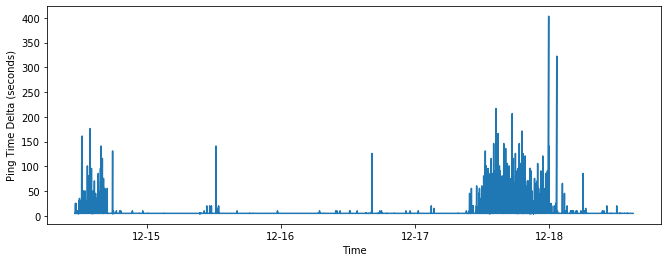

In [164]:
pe.plot_ping_timediff()

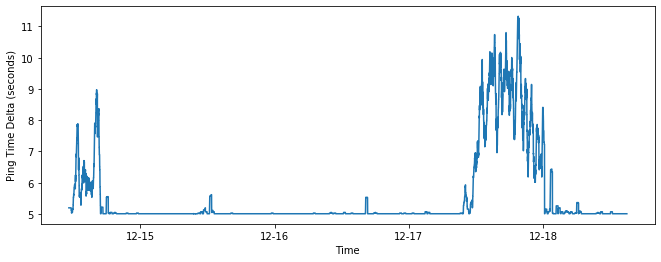

In [165]:
pe.plot_ping_timediff(rolling=True)

### Plotting Latency (Raw and Rolling Mean)

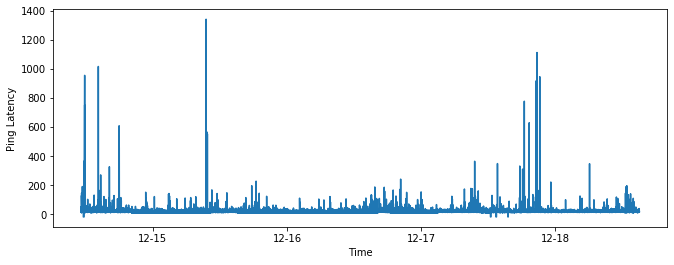

In [166]:
pe.plot_ping_latency()

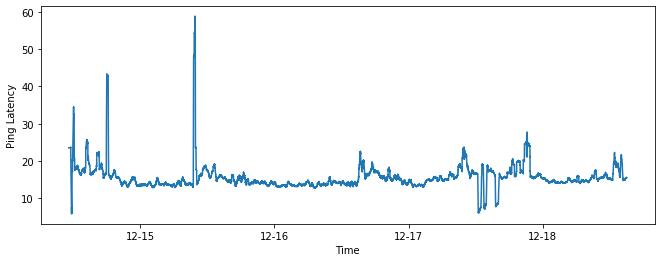

In [167]:
pe.plot_ping_latency(rolling=True)